# Importando bibliotecas

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import seaborn as sns
import suporte.suportedata as sd

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


sns.set_theme(style='darkgrid')
SEED = 42

# Importando os dados 

In [2]:
clientes = pd.read_json("../dados/Telco-Customer-Churn-limpeza.json")
clientes.head()

,customerID,Churn,Genero,Maior65anos,Conjuge,Dependentes,MesesDeContrato,ServicoTelefonico,MultiplasLinhas,ServicoInternet,...,ProtecaoDoDispositivo,SuporteTecnico,TVaCabo,StreamingDeFilmes,TipoDeContrato,PagamentoOnline,FormaDePagamento,GastoMensal,GastoTotal,GastoDiario
0,0002-ORFBO,Não,Mulher,0,Sim,Sim,9,Sim,Não,DSL,...,Não,Sim,Sim,Não,Um Ano,Sim,Envio de Cheque,65.6,593.30,2.19
1,0003-MKNFE,Não,Homem,0,Não,Não,9,Sim,Sim,DSL,...,Não,Não,Não,Sim,Mensal,Não,Envio de Cheque,59.9,542.40,2.00
2,0004-TLHLJ,Sim,Homem,0,Não,Não,4,Sim,Não,Fibra Optica,...,Sim,Não,Não,Não,Mensal,Sim,Cheque Eletronico,73.9,280.85,2.46
3,0011-IGKFF,Sim,Homem,1,Sim,Não,13,Sim,Não,Fibra Optica,...,Sim,Não,Sim,Sim,Mensal,Sim,Cheque Eletronico,98.0,1237.85,3.27
4,0013-EXCHZ,Sim,Mulher,1,Sim,Não,3,Sim,Não,Fibra Optica,...,Não,Sim,Sim,Não,Mensal,Sim,Envio de Cheque,83.9,267.40,2.80


# Preparação para os modelos

Para usarmos os dados da nossa tabela de clientes eles precisam prepara-los para serem usados em nosso modelo, pois os valores categóricos não são lidos pelo modelo sendo assim é preciso modificar os valores para zeros e uns. Porém na nossa base de dados existem algumas variáveis quantitativas e essas variáveis precisam ser tratadas separadamente das variáveis categóricas, por isso elas serão separadas antes da preparação dos dados para o modelo. 


In [3]:
# retirando as variáveis quantitativas
clientes.drop(['GastoTotal','GastoDiario','customerID'], axis=1, inplace=True)

In [4]:
colunas = ['ServicoInternet','TipoDeContrato','TipoDeContrato']

clientes2 = clientes.drop(colunas, axis=1)
clientes2.columns

Index(['Churn', 'Genero', 'Maior65anos', 'Conjuge', 'Dependentes',
       'MesesDeContrato', 'ServicoTelefonico', 'MultiplasLinhas',
       'SeguroOnline', 'OnlineBackup', 'ProtecaoDoDispositivo',
       'SuporteTecnico', 'TVaCabo', 'StreamingDeFilmes', 'PagamentoOnline',
       'FormaDePagamento', 'GastoMensal'],
      dtype='object')

In [5]:
# avaliando as variáveis que restaram
sd.tipo_variaveis_categoricas(clientes)

Valores da variável Churn: ['Não' 'Sim']
Valores da variável Genero: ['Mulher' 'Homem']
Valores da variável Conjuge: ['Sim' 'Não']
Valores da variável Dependentes: ['Sim' 'Não']
Valores da variável ServicoTelefonico: ['Sim' 'Não']
Valores da variável MultiplasLinhas: ['Não' 'Sim' 'SemServicoTelefonico']
Valores da variável ServicoInternet: ['DSL' 'Fibra Optica' 'Não']
Valores da variável SeguroOnline: ['Não' 'Sim' 'SemServicoInternet']
Valores da variável OnlineBackup: ['Sim' 'Não' 'SemServicoInternet']
Valores da variável ProtecaoDoDispositivo: ['Não' 'Sim' 'SemServicoInternet']
Valores da variável SuporteTecnico: ['Sim' 'Não' 'SemServicoInternet']
Valores da variável TVaCabo: ['Sim' 'Não' 'SemServicoInternet']
Valores da variável StreamingDeFilmes: ['Não' 'Sim' 'SemServicoInternet']
Valores da variável TipoDeContrato: ['Um Ano' 'Mensal' 'Dois Anos']
Valores da variável PagamentoOnline: ['Sim' 'Não']
Valores da variável FormaDePagamento: ['Envio de Cheque' 'Cheque Eletronico' 'Cartao 

In [6]:
# criando o dicionário para a conversão para o modelo 
dicionario = {'Não':0,
              'Sim':1,
             }

In [7]:
clientes_mapeados = clientes2[['Churn','Conjuge','Dependentes', 'PagamentoOnline' ]].replace(dicionario)
clientes_mapeados.head()

,Churn,Conjuge,Dependentes,PagamentoOnline
0,0,1,1,1
1,0,0,0,0
2,1,0,0,1
3,1,1,0,1
4,1,1,0,1


In [8]:
dummie_clientes = pd.get_dummies(clientes2.drop(['Churn','Conjuge','Dependentes', 'PagamentoOnline'],
                                           axis = 1))

clientes2 = pd.concat([clientes_mapeados, dummie_clientes], axis=1)
pd.set_option('display.max_columns', 40)
clientes2

,Churn,Conjuge,Dependentes,PagamentoOnline,Maior65anos,MesesDeContrato,GastoMensal,Genero_Homem,Genero_Mulher,ServicoTelefonico_Não,ServicoTelefonico_Sim,MultiplasLinhas_Não,MultiplasLinhas_SemServicoTelefonico,MultiplasLinhas_Sim,SeguroOnline_Não,SeguroOnline_SemServicoInternet,SeguroOnline_Sim,OnlineBackup_Não,OnlineBackup_SemServicoInternet,OnlineBackup_Sim,ProtecaoDoDispositivo_Não,ProtecaoDoDispositivo_SemServicoInternet,ProtecaoDoDispositivo_Sim,SuporteTecnico_Não,SuporteTecnico_SemServicoInternet,SuporteTecnico_Sim,TVaCabo_Não,TVaCabo_SemServicoInternet,TVaCabo_Sim,StreamingDeFilmes_Não,StreamingDeFilmes_SemServicoInternet,StreamingDeFilmes_Sim,FormaDePagamento_Cartao Credito,FormaDePagamento_Cheque Eletronico,FormaDePagamento_Envio de Cheque,FormaDePagamento_Transferencia Bancaria
0,0,1,1,1,0,9,65.60,0,1,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0
1,0,0,0,0,0,9,59.90,1,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0
2,1,0,0,1,0,4,73.90,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0
3,1,1,0,1,1,13,98.00,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0
4,1,1,0,1,1,3,83.90,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,0,0,0,13,55.15,0,1,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0
7039,1,1,0,1,0,22,85.10,1,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0
7040,0,0,0,1,0,2,50.30,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
7041,0,1,1,0,0,67,67.85,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0


# Balanceando as variáveis

É preciso balancear as quantidade de dados, pois quando se tem mais de um dado que outro o modelo pode interpretar de forma inadequada estas informações e gerar previsões equivocadas, por isso agora é preciso ser feito um processo de balanceamento, ou seja, fazer com que as métricas possuam a mesma quantidade de forma a treinar o modelo com uma maior precisão.

In [9]:
X = clientes2.drop(['Churn'], axis=1)
y = clientes2.Churn

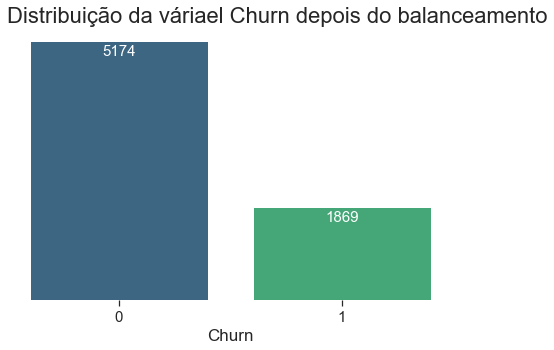

In [10]:
sd.plot_categorica(dataset = clientes2,
                    x = 'Churn',
                    titulo = 'Distribuição da váriael Churn depois do balanceamento',
                    label_x='Churn')
                

## Modificando as escalas dos dados.

In [11]:
from sklearn.preprocessing import StandardScaler

norm = StandardScaler()


X_normalizado = norm.fit_transform(X)
X_normalizado

array([[ 1.03453023,  1.5290241 ,  0.8297975 , ..., -0.71102597,
         1.83551265, -0.5298852 ],
       [-0.96662231, -0.65401193, -1.20511329, ..., -0.71102597,
         1.83551265, -0.5298852 ],
       [-0.96662231, -0.65401193,  0.8297975 , ...,  1.40641839,
        -0.54480692, -0.5298852 ],
       ...,
       [-0.96662231, -0.65401193,  0.8297975 , ..., -0.71102597,
         1.83551265, -0.5298852 ],
       [ 1.03453023,  1.5290241 , -1.20511329, ..., -0.71102597,
         1.83551265, -0.5298852 ],
       [ 1.03453023,  1.5290241 , -1.20511329, ...,  1.40641839,
        -0.54480692, -0.5298852 ]])

## Aplicando o balanceamento

In [12]:
sm = SMOTE(random_state=SEED)
X_res, y_res = sm.fit_resample(X_normalizado, y)

In [13]:
clientes4 = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res)], axis=1)

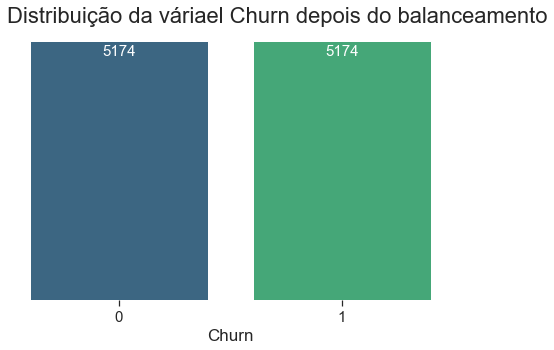

In [14]:
sd.plot_categorica(dataset = clientes4,
                    x = 'Churn',
                    titulo = 'Distribuição da váriael Churn depois do balanceamento',
                    label_x='Churn')
                

In [15]:
clientes.to_json("../dados/Telco-Customer-Churn-balanceamento.json")

# Criando os modelos

In [16]:
#separação dos modelos 
X_treino, X_teste, y_treino, y_teste = train_test_split(X_res, y_res, random_state=SEED)

## SVC

In [17]:
svc = SVC(random_state=SEED)
svc.fit(X_treino, y_treino)
y_pred_svc = svc.predict(X_teste)

In [18]:
from sklearn.metrics import accuracy_score

acuracia = accuracy_score(y_teste, y_pred_svc)
round(acuracia*100,2)

79.28

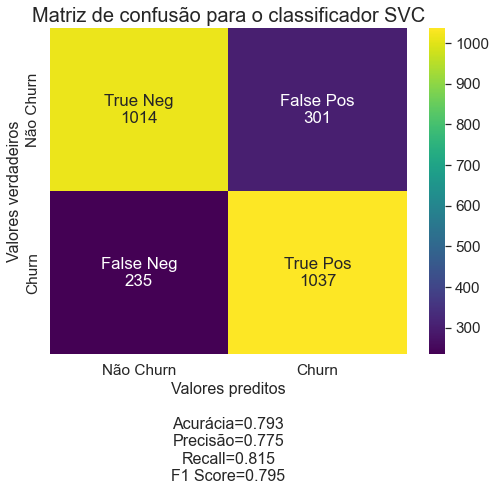

In [19]:
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Não Churn", "Churn"]
sd.plot_matriz_confusao(y_teste,
                      y_pred_svc,
                      group_names=labels,
                      categories=categories,
                      figsize=(8, 6), 
                      title="Matriz de confusão para o classificador SVC"
            )

## Decision Tree

In [20]:
dtree = DecisionTreeClassifier(max_depth=5, random_state=SEED)
dtree.fit(X_treino, y_treino)
y_pred_dt = dtree.predict(X_teste)

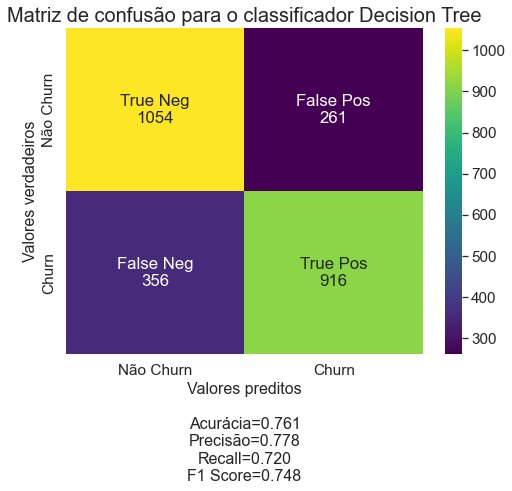

In [21]:
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Não Churn", "Churn"]
sd.plot_matriz_confusao(y_teste,
                      y_pred_dt,
                      group_names=labels,
                      categories=categories,
                      figsize=(8, 6), 
                      title="Matriz de confusão para o classificador Decision Tree")

In [22]:
rforest = RandomForestClassifier(max_depth = 5, random_state=SEED)
rforest.fit(X_treino, y_treino)
y_pred_rf = rforest.predict(X_teste)

# Random Forest

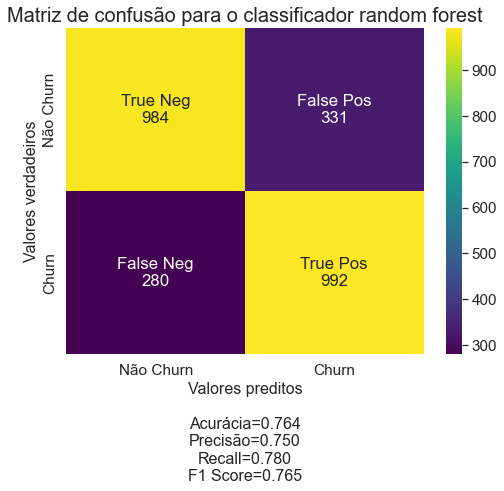

In [23]:
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Não Churn", "Churn"]
sd.plot_matriz_confusao(y_teste,
                      y_pred_rf,
                      group_names=labels,
                      categories=categories,
                      figsize=(8, 6), 
                      title="Matriz de confusão para o classificador random forest")

# Tabela de modelos

In [24]:
modelos = ['svc', 'decision tree', 'random forest']
y_pred_treinos = [svc.predict(X_treino), dtree.predict(X_treino), rforest.predict(X_treino)]
y_pred_testes = [y_pred_svc, y_pred_dt, y_pred_rf]

In [25]:
tabelo_modelos = sd.compara_modelos_metricas('Recall', modelos, y_treino, y_pred_treinos, y_teste, y_pred_testes)
tabelo_modelos.round(4)

,Modelo,Acurácia Treino,Acurácia Teste,Precisão,Recall,F1-Score
0,svc,0.8219,0.7928,0.7750,0.8153,0.7946
1,random forest,0.7886,0.7638,0.7498,0.7799,0.7645
2,decision tree,0.7789,0.7615,0.7782,0.7201,0.7481
